# Script for shear bias measurement 

Here I show some scripts and functions that allow us to measure shear bias as a function of some properties. We can do it using different methods, as specified in Pujol et al. (2018). 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

In [17]:
#where the data files are
data_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'/data/'

With these functions I measure bias as a function of other properties by measuring the mean bias for each bin in whatever property. The Jack-Knife errors are also obtained.  

In [3]:
def get_jk_indeces_1d(array, jk_num, rand_order = True):
    """
    It assigns equally distributed indeces to the elements of an array.
    Input:
    array: data array.
    jk_num: number of JK subsamples to identify. 
    rand_order: if True, the indeces are assigned in a random order. 
    Output:
    jk_indeces: array assigning an index (from 0 to jk_num - 1) to
        each of the data elements. 
    """
    ratio = len(array)/jk_num + int(len(array)%jk_num > 0)
    jk_indeces = np.arange(len(array), dtype = int)/ratio
    np.random.shuffle(jk_indeces)
    return jk_indeces

def jack_knife(var, jk_var):
	"""
		It gives the Jack-Knife error of var from the jk_var subsamples.
		Inputs: 
		var: the mean value of the variable. Constant number.
		jk_var: the variable from the subsamples. The shape of the jk_var must be (jk subsamples, bins)

	 	Output: 
		jk_err: the JK error of var. 
		"""
	if type(var) == np.ndarray:
		jk_dim = jk_var.shape[0]
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err, axis = 0))
	else:
		jk_dim = len(jk_var)
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err))
	return jk_err

def get_bin_edges(array, nbins, equal_bins = True):
    """From an array, it defines the bin edges
    which define the number of bins nbins.
    Input:
    array: array of values.
    nbins: number of bins.
    equal_bins: if True, each bin has the same
       number of elements. Otherwise, the bin separation
       is linear
    Output:
    bin_edges: array of nbins+1 elements.
    """    
    if equal_bins:
        lims = np.linspace(0,len(array[(array < np.inf)]) - 1, nbins + 1)
        lims = np.array(lims, dtype = int)
        bin_edges = np.sort(array[(array < np.inf)])[lims]
        return np.unique(bin_edges)
    else:
        return np.linspace(min(array), max(array), nbins + 1)



In [4]:
def plot_mean_per_bin(xvar, xname, yvar, yname, nbins, filter_arr, jk_num = 50, c  = 'k', show = True, marker = 's', ylims = None, leg_loc = 'upper center', equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1, error_mode = 'jk', save = False, out_name = '/tmp/plot.pdf', get_out = False):
    """
    It plots the mean value of a variable as a function of another one. 
    Input:
    xvar: array, variable that is binned in the x axis.
    xname: string, name of the variable that appears in x label.
    yvar: array, variable which mean is calculated in each x bin. 
    yname: string, name of the variable, shown in the legend. 
    nbins: integer, specifies the number of x bins used. 
    filter_array: boolean array which defines a selection of the objects in 
    xvar and yvar. 
    jk_num: integer, number of Jack-Knife subsamples used to calculate the error bars.
    c: colour of the error bars and points used.
    show: if True, it shows the plot.
    marker: marker of plotted points.
    ylims: None or [a,b], defining (if not None0 the y axes limits.
    leg_loc: position of legend. 
    equal_bins: if True, each bin has the same number of elements. Otherwise, 
        bins are defined linearly according to the min and max values. 
    linestyle: string, linestyle of the plot. 
    lw: float, line width of the plot.
    leg_ncol: integer, number of columns in the legend.
    error_mode: 'jk' or 'std', specifies if the errors are JK or the standard deviation. 
    save: if True, it saves the plots. 
    out_name: name of the output plot file. 
    get_out: if True, it returns the mean xvar, mean yvar and its error.
    Output:
    It generates a plot that can be saved and/or shown if specified. 
    x_plot: mean x for each bin. 
    y_plot, err_plot: mean y for each bin and its error.
    """
    xvar_f = xvar[filter_arr]
    yvar_f = yvar[filter_arr]
    bin_edges = get_bin_edges(xvar_f, nbins, equal_bins = equal_bins)
    nbins = len(bin_edges) - 1
    random_amplitude = (bin_edges[1] - bin_edges[0])/20.
    x_plot = []
    y_plot = []
    err_plot = []
    for i in range(nbins):
        filter_bin = (xvar_f >= bin_edges[i])*(xvar_f < bin_edges[i+1])
        jk_indeces = get_jk_indeces_1d(xvar_f[filter_bin], jk_num)
        np.random.shuffle(jk_indeces)
        if error_mode == 'jk':
            sub_mean = [np.mean(yvar_f[filter_bin][jk_indeces != j]) for j in range(jk_num)]
            mean = np.mean(sub_mean)
            err = jack_knife(mean, sub_mean)
        elif error_mode == 'std':
            mean = np.mean(yvar_f[filter_bin])
            err = np.std(yvar_f[filter_bin])
        else:
            print("WRONG error_model in plot_mean_per_bin")
        rand =  np.random.random()*random_amplitude
        x_plot.append(np.mean(xvar_f[filter_bin]) + rand)
        y_plot.append(mean)
        err_plot.append(err)
    plt.errorbar(x_plot, y_plot, err_plot, c = c, marker = marker, markersize = 5, label = yname, linestyle = linestyle, lw = lw)
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.xlabel(xname)
    #plt.ylabel(yname)
    plt.axhline(0, c = 'k', lw = 1)
    if show:
        plt.legend(loc = leg_loc, frameon = False, fontsize = 10, ncol = leg_ncol)
        if save:
            plt.savefig(out_name)
            print("Plot saved in " + out_name)
        plt.show()
    if get_out:
        return x_plot, y_plot, err_plot

Here I define a function to estimate shear biases from the linear fit method.  

In [5]:
def jk2err(jk_sub):
    """
    It returns the Jack-Knife error from the measurements
    of the subsamples.
    Input:
    jk_sub: array with the results of each JK subsample.
    Output:
    mean, jk_err: mean value of the measurement and its JK error.
    """
    jk_dim = len(jk_sub)
    mean = np.mean(jk_sub)
    err = (jk_dim - 1.)/jk_dim*(jk_sub - mean)**2.
    jk_err = np.sqrt(np.sum(err))
    return mean, jk_err

def bias_scatter_jk_err(x_var, y_var, jk_dim = 50):
    """
    From a given data x_var and y_var, it measures the mean additive and 
    multiplicative bias from a linear fit to the scatter distribution of
    x_var and y_var. It also computes the Jack-Knife error.
    Input:
    x_var: array with a discrete number of different values in it.
    y_var: array with the same dimension as x_var.
    jk_dim: number of JK subsamples used.
    Output:
    b, b_err, a, a_err: values and JK errors of multiplicative and additive bias.
    """
    ratio = len(x_var)/jk_dim + int(len(x_var)%jk_dim > 0)
    jk_indexes = np.arange(len(x_var), dtype=int)/ratio
    np.random.shuffle(jk_indexes)
    
    sub_b = np.array([np.polyfit(x_var[jk_indexes != i], y_var[jk_indexes != i], 1)[0] for i in range(jk_dim)]) - 1.
    sub_a = np.array([np.polyfit(x_var[jk_indexes != i], y_var[jk_indexes != i], 1)[1] for i in range(jk_dim)])
    b, b_err = jk2err(sub_b)
    a, a_err = jk2err(sub_a)
    return b, b_err, a, a_err

In [6]:
def make_bias_plots(var, g1_intrinsic, g1, final_e1, g2_intrinsic, g2, final_e2, nbins, var_name, filter_disk, title_name, orth_bins = False, show = False, out_dir = '', one_component = False, many_shears = True):
    """
    It calculates and generates the plots of the biases a, b, c, m as a 
    function of a galaxy property var. It also applies a filter to define
    a subset of galaxies (e.g. with or without disk).
    Input:
    var: the property as a function of which we calculate the bias. 
    g{1,2}_intrinsic, g{1,2}, final_e{1,2}: the intrinsic shear, the shear and 
    the shear measurement of the galaxies.
    bin_edges: the edges that define the bins in var.
    filter_disk: a boolean array that filters the galaxies used according to, e.g.,
    the presence of a disk.
    title_name: string that defines the title of the plots.
    orth_bins: if true, in each bin we also select the galaxies within bin_edges + np.pi/2.
    show: if True, it shows the output plots in windows.
    out_dir: directory to save the output plots.
    one_component: if True, bias for g1 is computed only for g2 = 0, and viceversa. 
    shear to compute c and m. 
    many_shears: if True, m and c are obtained from the same fitting as a and b.
    Output:
    left plot: multiplicative biases b and m as a function of var.
    right plot: additive biases a and c as a function of var.
    """
    b1, b2, a1, a2, m1, m2, c1, c2, mean_var, mean_ellip1, mean_ellip2 = [], [], [], [], [], [], [], [], [], [], []
    b1_err, b2_err, a1_err, a2_err, m1_err, m2_err, c1_err, c2_err = [], [], [], [], [], [], [], []
    
    bin_edges = get_bin_edges(var, nbins)
    
    for i in range(len(bin_edges) - 1):
        #generate filter array
        if orth_bins:
            filter = filter_disk*(var > bin_edges[i])*(var < bin_edges[i + 1]) + filter_disk*(var > bin_edges[i] + np.pi/2)*(var < bin_edges[i + 1] + np.pi/2) + filter_disk*(var > bin_edges[i] - np.pi/2)*(var < bin_edges[i + 1] - np.pi/2)
        else:
            filter = filter_disk*(var > bin_edges[i])*(var < bin_edges[i + 1])
        if one_component:
            filter1 = filter*(g2 == 0)
            filter2 = filter*(g1 == 0)
        else:
            filter1, filter2 = filter, filter
        #calculate c,m
        m1bin, m1bin_err, c1bin, c1bin_err = bias_scatter_jk_err(g1[filter*filter1], final_e1[filter*filter1])
        m2bin, m2bin_err, c2bin, c2bin_err = bias_scatter_jk_err(g2[filter*filter2], final_e2[filter*filter2])        
        m1.append(m1bin)
        c1.append(c1bin)
        m1_err.append(m1bin_err)
        c1_err.append(c1bin_err)
        m2.append(m2bin)
        c2.append(c2bin)
        m2_err.append(m2bin_err)
        c2_err.append(c2bin_err)
        #calculate mean ellipticities
        if orth_bins:
            mean_var.append(np.mean(var[filter]) - np.pi/4.)
        else:
            mean_var.append(np.mean(var[filter]))
        mean_ellip1.append(np.mean(g1_intrinsic[filter]))
        mean_ellip2.append(np.mean(g2_intrinsic[filter]))
        
    print("mean g1_intrinsic in the bins: " + str(mean_ellip1))
    print("mean g2_intrinsic in the bins: " + str(mean_ellip2))
    
    #generating plots
    plt.errorbar(mean_var, m1, m1_err, label = 'm1', c = 'g', lw = 3)
    plt.errorbar(mean_var, m2, m2_err, label = 'm2', c = 'b', linestyle = '--', lw = 3)
    plt.legend(loc = 'center left', frameon = False)
    plt.xlabel(var_name)
    if title_name == 'disk':
        plt.title('disk + bulge')
    elif title_name == 'no_disk':
        plt.title('bulge')
    else:
        plt.title(title_name)
    if show:
        plt.show()
    else:
        plt.close()
    
    plt.errorbar(mean_var, c1, c1_err, label = 'c1', c = 'r', lw = 3)
    plt.errorbar(mean_var, c2, c2_err, label = 'c2', c = 'm', linestyle = '--', lw = 3)
    plt.legend(loc = 'lower left', frameon = False)
    plt.xlabel(var_name)
    if title_name == 'disk':
        plt.title('disk + bulge')
    elif title_name == 'no_disk':
        plt.title('bulge')
    else:
        plt.title(title_name)
    if show:
        plt.show()
    else:
        plt.close()

Here I load some ksb output properties and galsim input properties of $1990000$ objects. It also loads the multiplicative and additive biases obtained as in Pujol et al. (2018)

In [19]:
#loading KSB properties
ksb_X = np.load(data_path + 'KSB_data_s10.npy')
ksb_props = ['final_gal_id', 'final_e1', 'final_e2', 'scale', 'out_sn', 'out_beta', 'out_q', 'final_ep', 'final_ex']
ksb = {}
for i in range(len(ksb_props)):
    ksb[ksb_props[i]] = ksb_X[i]
#loading galsim properties
galsim_X = np.load(data_path + 'galsim_data.npy')
galsim_props = ['index', 'x', 'y', 'g1', 'g2', 'mu', 'ID', 'bulge_n', 'bulge_hlr', 'bulge_q', 'bulge_beta_radians', 'bulge_flux', 'disk_hlr', 'disk_q', 'disk_beta_radians', 'disk_flux', 'gal_sn', 'g1_intrinsic', 'g2_intrinsic', 'psf_theta', 'in_beta', 'in_q', 'gp', 'gx', 'gp_intrinsic', 'gx_intrinsic']
galsim = {}
for i in range(len(galsim_props)):
    galsim[galsim_props[i]] = galsim_X[i]
#loading biases
m1 = np.load('/Users/apujol/Documents/physics/cea/shapelens/output/ksbtt/multishear/individual_bias/m1A.npy')
m2 = np.load('/Users/apujol/Documents/physics/cea/shapelens/output/ksbtt/multishear/individual_bias/m2A.npy')
c1 = np.load('/Users/apujol/Documents/physics/cea/shapelens/output/ksbtt/multishear/individual_bias/c1.npy')
c2 = np.load('/Users/apujol/Documents/physics/cea/shapelens/output/ksbtt/multishear/individual_bias/c2.npy')
#loading a filter that removes objects for which some ellipticities have not been correctly measured
data_filter = np.load(data_path + 'ksb_gfit_mask_for_ksb.npy')

An example of multiplicative bias as a function of the SNR measured by KSB: 

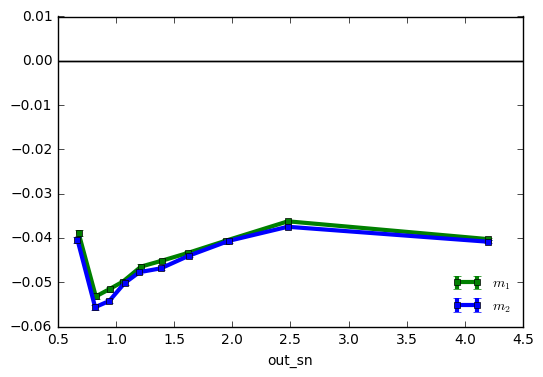

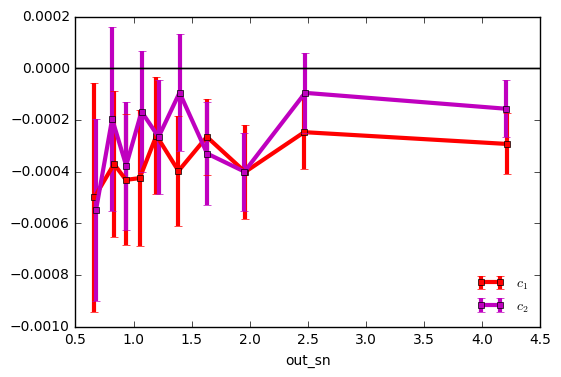

In [20]:
xname = 'out_sn'
yvar = m1
yname = r'$m_1$'
nbins = 10
filter_arr = data_filter
plot_mean_per_bin(ksb[xname], xname, yvar, yname, nbins, filter_arr, c  = 'g', show = False, marker = 's', equal_bins = True, linestyle = '-', lw = 3)
yvar = m2
yname = r'$m_2$'
plot_mean_per_bin(ksb[xname], xname, yvar, yname, nbins, filter_arr, c  = 'b', show = True, marker = 's', ylims = None, leg_loc = 4, equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1)

yvar = c1
yname = r'$c_1$'
plot_mean_per_bin(ksb[xname], xname, yvar, yname, nbins, filter_arr, c  = 'r', show = False, marker = 's', equal_bins = True, linestyle = '-', lw = 3)
yvar = c2
yname = r'$c_2$'
plot_mean_per_bin(ksb[xname], xname, yvar, yname, nbins, filter_arr, c  = 'm', show = True, marker = 's', ylims = None, leg_loc = 4, equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1)

The same but using the linear fit method to estimate bias 

mean g1_intrinsic in the bins: [0.00021553769878127332, -0.00010365060737632562, 0.00020929820537323148, -0.00026861814834259611, 2.6789553450671167e-05, -7.8649946291556845e-05]
mean g2_intrinsic in the bins: [0.00016589865444160317, 0.00036140788956532494, -1.5988648933154222e-05, 4.0963232463719485e-05, -0.00040128349595566261, -0.00014589058451949731]


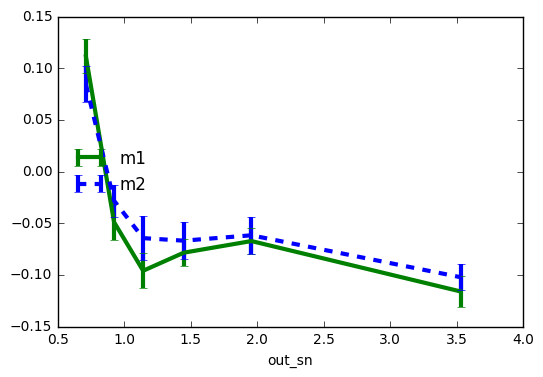

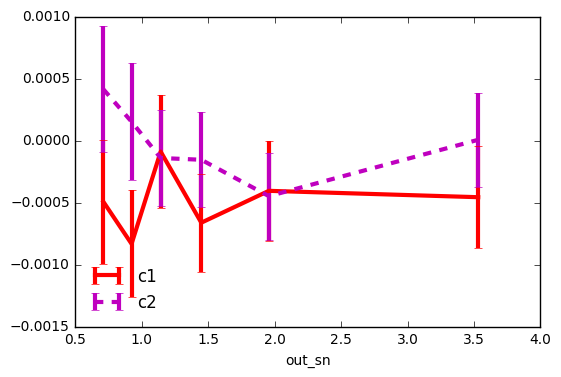

In [21]:
var_name = 'out_sn'
var = ksb[var_name]
filter_arr = data_filter
nbins = 6
make_bias_plots(var, galsim['g1_intrinsic'], galsim['g1'], ksb['final_e1'], galsim['g2_intrinsic'], galsim['g2'], ksb['final_e2'], nbins, var_name, filter_arr, '', orth_bins = False, show = True, out_dir = '', one_component = False, many_shears = True)

An example of multiplicative bias as a function of the input galsim flux of galaxies with no disk:

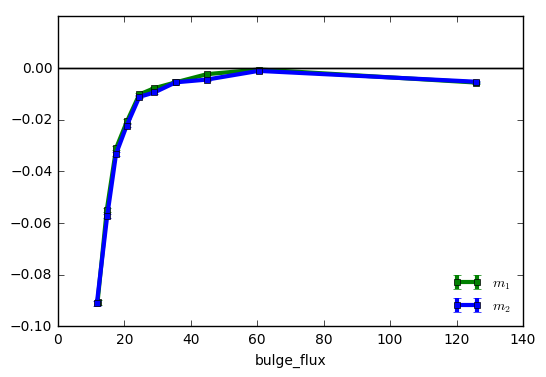

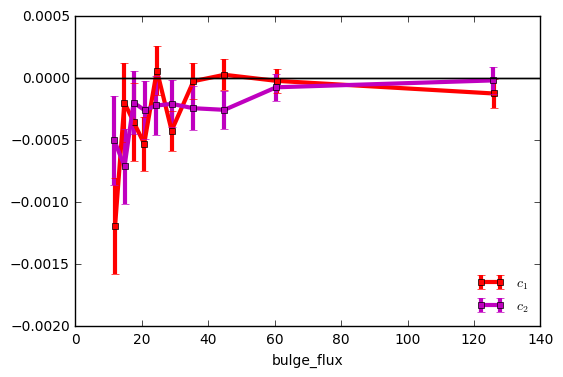

In [20]:
xname = 'bulge_flux'
yvar = m1
yname = r'$m_1$'
nbins = 10
filter_arr = data_filter*(galsim['disk_flux'] == 0.)
plot_mean_per_bin(galsim[xname], xname, yvar, yname, nbins, filter_arr, c  = 'g', show = False, marker = 's', equal_bins = True, linestyle = '-', lw = 3)
yvar = m2
yname = r'$m_2$'
plot_mean_per_bin(galsim[xname], xname, yvar, yname, nbins, filter_arr, c  = 'b', show = True, marker = 's', ylims = None, leg_loc = 4, equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1)

yvar = c1
yname = r'$c_1$'
plot_mean_per_bin(galsim[xname], xname, yvar, yname, nbins, filter_arr, c  = 'r', show = False, marker = 's', equal_bins = True, linestyle = '-', lw = 3)
yvar = c2
yname = r'$c_2$'
plot_mean_per_bin(galsim[xname], xname, yvar, yname, nbins, filter_arr, c  = 'm', show = True, marker = 's', ylims = None, leg_loc = 4, equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1)

The same but using the linear fit method to estimate bias 

mean g1_intrinsic in the bins: [-2.2303587548273236e-18, -1.1427926141277989e-19, -5.957010957223606e-21, 3.659961645815769e-19, 6.0813187192469539e-19]
mean g2_intrinsic in the bins: [2.8746846173329949e-17, 4.4633598325368749e-19, 5.3613098615012456e-20, -7.2090153629704543e-20, 2.6704393577531537e-20]


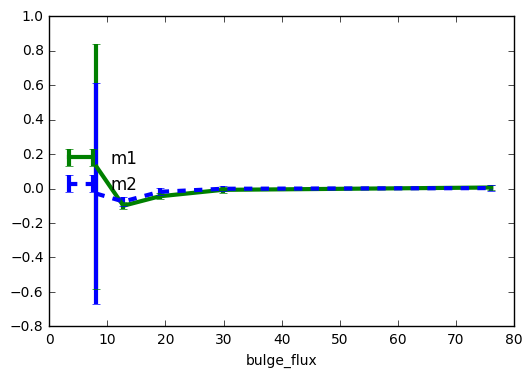

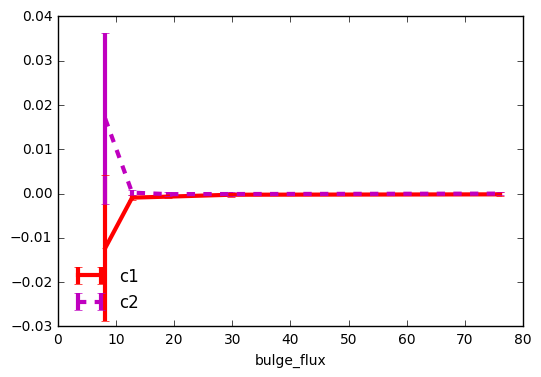

In [29]:
var_name = 'bulge_flux'
var = galsim[var_name]
filter_arr = data_filter*(galsim['disk_flux'] == 0.)
nbins = 5
make_bias_plots(var, galsim['g1_intrinsic'], galsim['g1'], ksb['final_e1'], galsim['g2_intrinsic'], galsim['g2'], ksb['final_e2'], nbins, var_name, filter_arr, '', orth_bins = False, show = True, out_dir = '', one_component = False, many_shears = True)